In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import kagglehub
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
import tqdm
import pickle
import PIL
import sklearn
import time
import warnings
warnings.filterwarnings('ignore')

#Preprocess

In [ ]:
path = kagglehub.dataset_download("ntl0601/casia-webface")

In [ ]:
path = path + "//" + "casia-webface"

In [ ]:
lengths = []

for sample_dir in tqdm.tqdm(os.listdir(path)):
    lengths.append(os.listdir(path+"//"+sample_dir).__len__())
lengths = np.array(lengths)

100%|██████████| 10572/10572 [01:48<00:00, 97.32it/s] 


In [ ]:
test_nums = []
nums = []
for i, sample_dir in tqdm.tqdm(enumerate(np.array(os.listdir(path)))):
    if (os.listdir(path+"//"+sample_dir).__len__() > 10) and (os.listdir(path+"//"+sample_dir).__len__()<17):
      test_nums.append(i)
    if os.listdir(path+"//"+sample_dir).__len__() > 10:
      nums.append(i)

train_nums = list(set(nums) - set(test_nums))

10572it [00:12, 866.47it/s]


In [ ]:
samples = []
for i, sample_dir in tqdm.tqdm(enumerate(np.array(os.listdir(path)))):
    if (os.listdir(path+"//"+sample_dir).__len__() > 10) and (os.listdir(path+"//"+sample_dir).__len__()>17):
      samples.append(path+"//" + sample_dir+'//' + os.listdir(path+"//"+sample_dir)[0])


10572it [00:15, 662.46it/s]


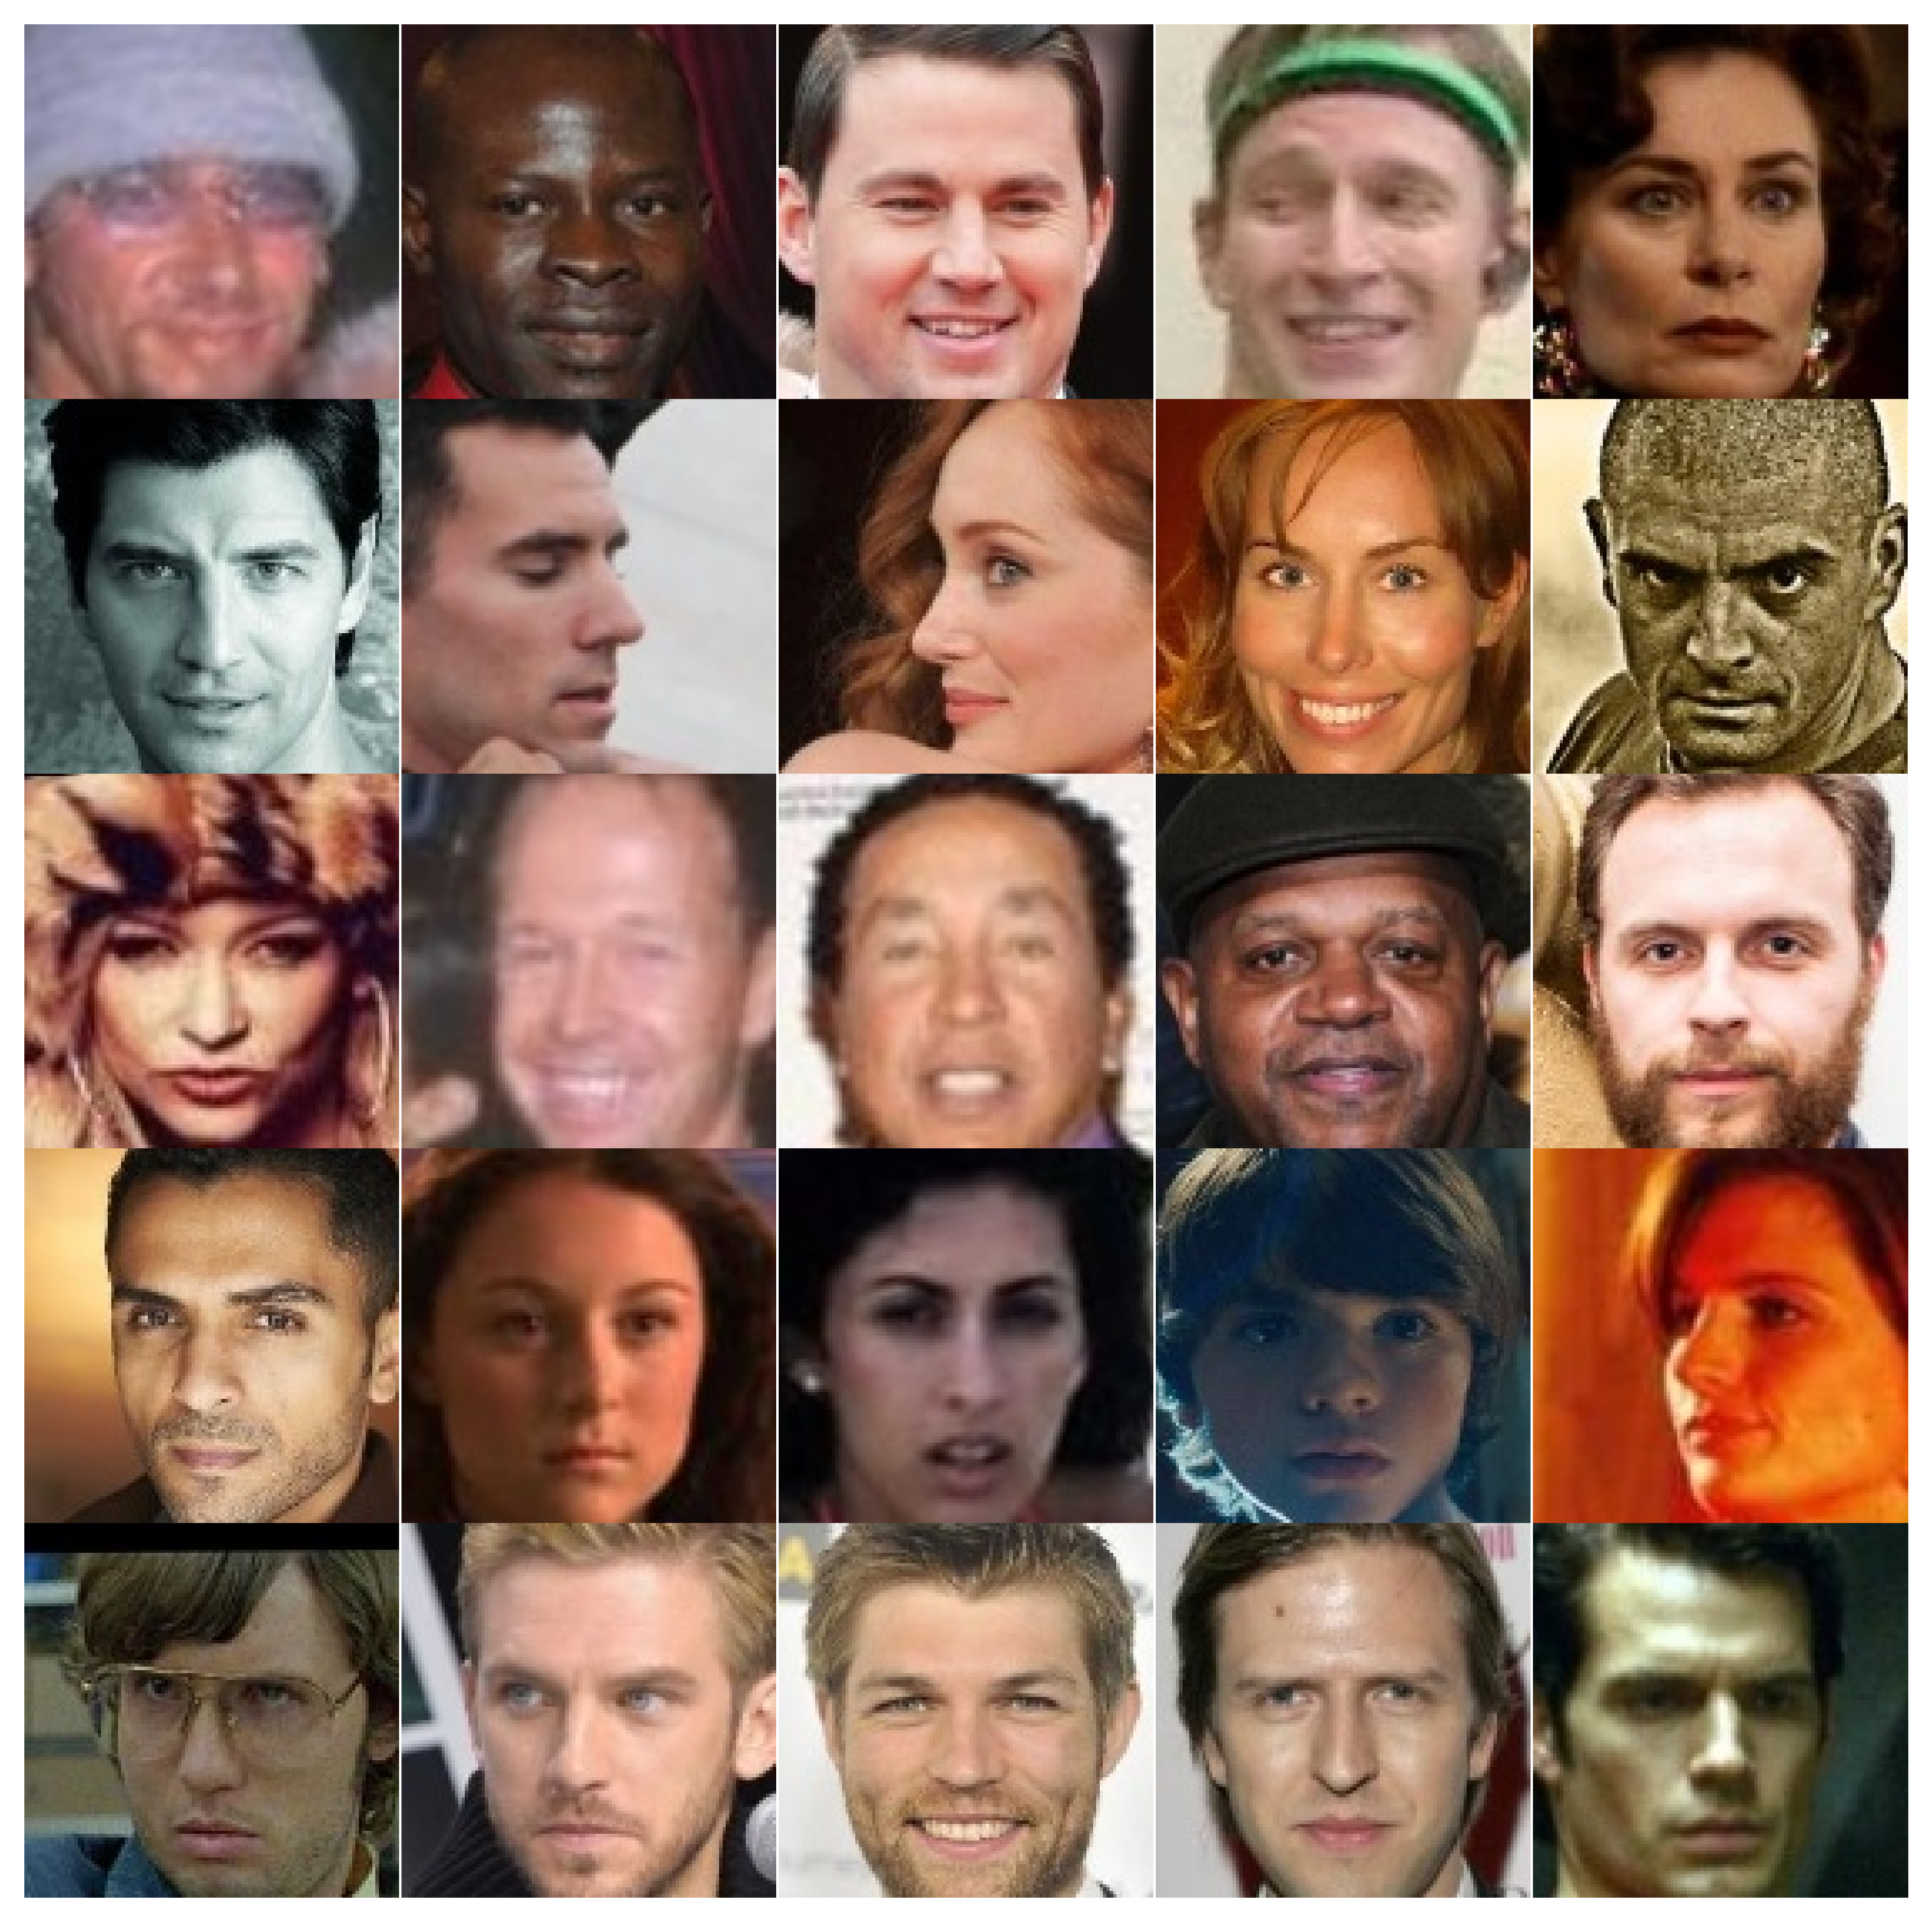

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(10,10), dpi=400)
plt.subplots_adjust(wspace=0, hspace=0)
for i in ax.flatten():
  img_path = samples[random.randint(0,1000)]

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB, cv2.CV_32FC3)
  i.axis('off')
  i.imshow(img)
plt.savefig('data.png')

#Utility

In [ ]:
class Faces_dataset(Dataset):

    def __init__(self, path, nums, pic_num = 10, resize=(112,112), func = None, val = False):
        self.nums = nums
        self.path = path
        self.pic_num = pic_num
        self.resize = resize
        self.func = func
        self.val = val
        self.dir = np.array(os.listdir(self.path))[self.nums]
        self.s = lengths[self.nums].sum()

    def __len__(self):
        return len(self.dir)

    def __getitem__(self, idx):
        data = []
        if self.val != True:
          sample_dir = np.random.choice(self.dir,p=lengths[self.nums]/self.s)
        else: sample_dir =self.dir[idx]
        path = self.path+"//"+sample_dir
        choice = set(os.listdir(path))
        num = 0
        while num < self.pic_num:

            img_name = random.choice(list(choice))
            choice.remove(img_name)
            img_path = path + "//" + img_name
            if self.func != None:
              img = PIL.Image.open(img_path)
              img_cropped = self.func(img)
              if img_cropped != None:
                data.append(img_cropped.numpy())
                num += 1
              continue
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB, cv2.CV_32FC3)
            num += 1

            if self.val == False:
              rot_matrix = cv2.getRotationMatrix2D((self.resize[0]//2, self.resize[1]//2), np.random.normal(0,1,1)[0]*15,1)
              img_rotated = cv2.warpAffine(img, rot_matrix, self.resize).transpose(2,0,1)
            else: img_rotated = img.transpose(2,0,1)
            img_rotated = torch.FloatTensor(img_rotated)/255.0
            data.append((img_rotated - img_rotated.mean(dim=(1,2)).reshape(3,1,1))/img_rotated.std(dim=(1,2)).reshape(3,1,1))

        return np.array(data)

def collate_fn(batch):
    batch = torch.FloatTensor(np.array(batch))
    labels = [j for j in range(batch.shape[0]) for i in range(batch.shape[1])]

    return batch.flatten(end_dim=1), torch.ShortTensor(np.array(labels))

In [ ]:
def triplets(data, target, net, mode="beginning", margin=0.4, n=3):

  embeddings = net(data)
  triplets = []
  except_list = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  except_list = dict()

  for i in num_list:

    if i in except_list and except_list[i] < n:
      except_list[i] += 1
    elif  i not in except_list: except_list[i] = 1
    else: continue

    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    dist = torch.cdist(embeddings[i].unsqueeze(0), embeddings)
    if mode =="end_pos":
      positive_final = positive[torch.argmax(dist[0][positive])]
      negative_final = random.choice(negative)

    if mode == "end_neg":
      positive_final = random.choice(positive)
      negative_final = negative[torch.argmin(dist[0][negative])]

    if mode == "end":
      positive_final = positive[torch.argmax(dist[0][positive])]
      negative_final = negative[torch.argmin(dist[0][negative])]

    if mode == "beginning":
      positive_final = random.choice(positive)
      negative_final = random.choice(negative)

    if mode == "semi-hard":
      positive_final = positive[torch.argmax(dist[0][positive])]
      if ((dist[0][positive_final] <= dist[0][negative]) & (dist[0][negative] <= dist[0][positive_final] + margin)).sum() != 0:
        negative = negative[(dist[0][positive_final] <= dist[0][negative]) & (dist[0][negative] <= dist[0][positive_final] + margin)]
      negative_final = random.choice(negative)

    triplets.append((embeddings[i],embeddings[positive_final],embeddings[negative_final]))

  return triplets

In [ ]:
def cluster_loss(data, target, net, alpha = 0.4):
  embeddings = net(data)
  loss = torch.zeros(1).to(device)
  num_of_centers = len(set(target.cpu().numpy()))
  centers_of_cluster = torch.stack([embeddings[target == i].mean(axis=0) for i in range(num_of_centers)])
  for i in range(num_of_centers):
    dist = torch.cdist(centers_of_cluster[i].unsqueeze(0), embeddings[target == i])
    dist = F.relu(dist-0.1)
    loss += dist.mean()/num_of_centers*alpha

  for i in range(centers_of_cluster.shape[0]):
    mask = list(range(centers_of_cluster.shape[0]))
    mask.remove(i)
    nearest = torch.cdist(centers_of_cluster[i].unsqueeze(0), centers_of_cluster[mask]).argmin()
    loss += F.relu(0.5-torch.norm(centers_of_cluster[i] - centers_of_cluster[nearest]))/num_of_centers
  return loss

In [ ]:
def accuracy(data, target, net):
  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  distances_slice = []
  answers = []
  except_list = []
  for i in num_list:
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    positive_final = random.choice(positive)
    negative_final = random.choice(negative)
    distances_slice.append(dist[i][positive_final].item())
    distances_slice.append(dist[i][negative_final].item())
    answers.append(1)
    answers.append(0)
  return distances_slice, answers

In [ ]:
def train_face_net(net, loss, train_loader, val_loader, optimizer, scheduler, epoch=5, mode="beginning", p_mode=True, n = 3, margin=0.4):
  history = []
  for _ in range(epoch):
    tmp = 0
    num_of_batch = 0
    curr_time = time.time()
    for batch, target in tqdm.tqdm(train_loader):
      num_of_batch += 1
      batch = batch.to(device)
      target = target.to(device)
      if loss == "cluster_loss":
        l = cluster_loss(batch, target, net)
        tmp += l
      else:
        triplets_ = triplets(batch, target, net, mode, margin, n)
        l = torch.zeros(1, dtype = torch.float16).to(device)

        for triplet in triplets_:
          l += loss(triplet[0], triplet[1], triplet[2])
        tmp += l/len(triplets_)
        l = l/len(triplets_)
      l.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()
    curr_time = time.time() - curr_time
    # tqdm.tqdm.write(f" Step is {scheduler.get_last_lr()}")
    # print(max_acc(net, batch, target))

    print(f"Loss on train {_} epoch is {tmp.item()/num_of_batch}")
    dist = []
    answer = []
    for batch, target in tqdm.tqdm(val_loader):
      batch = batch.to(device)
      target = target.to(device)
      dist_, answer_ = accuracy(batch, target, net)
      dist.extend(dist_)
      answer.extend(answer_)
      acc_list = []
      ta_list = []
      fa_list = []
      dansity = 400

    for threshold in np.linspace(0,2,dansity):
      correct = 0
      ta = 0
      fa = 0
      for i in range(len(answer)):
        if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
          correct += 1
        if dist[i] < threshold and answer[i] == 1:
          ta += 1
        if dist[i] < threshold and answer[i] == 0:
          fa += 1
      acc_list.append(correct/len(answer))
      ta_list.append(ta/len(answer)*2)
      fa_list.append(fa/len(answer)*2)
    if p_mode:
      plt.plot(np.linspace(0,2,dansity), acc_list)
      plt.title("tr-acc")
      plt.show()
    max_thr = np.linspace(0,2,dansity)[np.array(acc_list).argmax()]
    max_arg = np.array(acc_list).argmax()
    ta_arr = np.array(ta_list)
    fa_arr = np.array(fa_list)
    VAR = ta_arr[fa_arr<0.01][-1]
    history.append((max_thr, np.array(acc_list)[max_arg],
                    VAR,
                    tmp.item()/num_of_batch, curr_time))
    print(f" Epoch [{_}] Max accuracy:", max(acc_list)," | " ,"Threshold: ", max_thr, "VAR: ", VAR)
  return np.array(history)

#Arch

In [ ]:
class Siamese_net(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(1,1),padding=(3,3)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(64)
                               )

    self.conv2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(128),
                               )
    self.conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(256),
                               )

    self.conv4 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(256)
                               )

    self.conv5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.MaxPool2d((2,2)),
                               nn.BatchNorm2d(256)
                              )
    self.conv6 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=(1,1),padding=(1,1)),
                               nn.ReLU(),
                               nn.AdaptiveMaxPool2d((1, 1)),
                               nn.BatchNorm2d(128))


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = torch.flatten(x, 1)
    return F.normalize(x)

#Experiment

In [ ]:
data_train = Faces_dataset(path, train_nums, pic_num=15)
train_loader = DataLoader(data_train, batch_size=96, collate_fn=collate_fn, num_workers=2)

data_val = Faces_dataset(path, test_nums, pic_num=10, val=True)
val_loader = DataLoader(data_val, batch_size=64, collate_fn=collate_fn, num_workers=2)

In [ ]:
device = "cuda"
model = torch.load("/content/cluster_loss_model.pth", weights_only=False)
model = model.to(device)
#optimizer = Adam(model.parameters(), lr=1e-3)
#sch = lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.001, step_size_up=50, mode='triangular', gamma=1.0)
#margin = 0.2
#loss = "cluster_loss"
#all_history = []

100%|██████████| 47/47 [03:25<00:00,  4.37s/it]


Loss on train 0 epoch is 0.6472739361702128


100%|██████████| 27/27 [00:17<00:00,  1.58it/s]


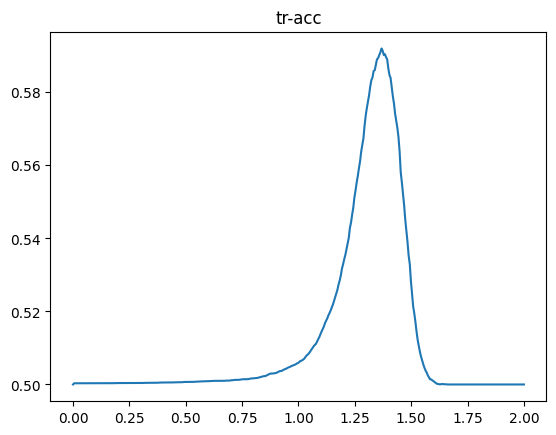

 Epoch [0] Max accuracy: 0.5919892793329363  |  Threshold:  1.3684210526315788 VAR:  0.07957117331745087


100%|██████████| 47/47 [03:29<00:00,  4.47s/it]


Loss on train 1 epoch is 0.616688829787234


100%|██████████| 27/27 [00:16<00:00,  1.64it/s]


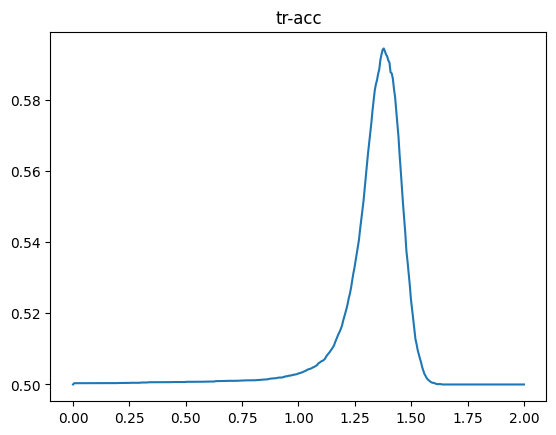

 Epoch [1] Max accuracy: 0.59434187016081  |  Threshold:  1.3784461152882206 VAR:  0.07516378796902919


100%|██████████| 47/47 [03:26<00:00,  4.39s/it]


Loss on train 2 epoch is 0.598404255319149


100%|██████████| 27/27 [00:15<00:00,  1.72it/s]


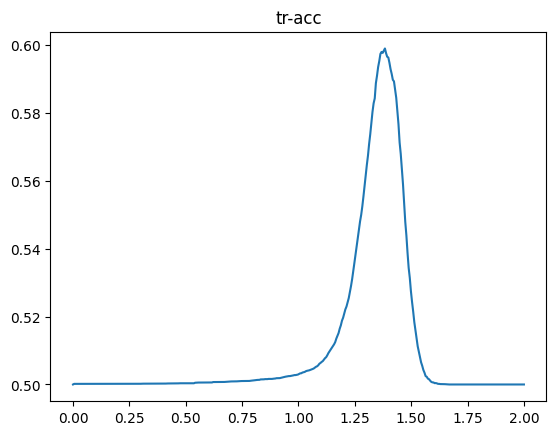

 Epoch [2] Max accuracy: 0.5989577129243597  |  Threshold:  1.3834586466165413 VAR:  0.08141751042287075


In [ ]:
history = train_face_net(model, loss, train_loader, val_loader, optimizer, sch, epoch=5, mode=None, n=5, margin=0.2)
all_history.extend(history)

In [ ]:
torch.save(model, 'cluster_loss_model.pth')
experiment = {'loss' : 'cluster_loss',
              'epoch_num' : '30',
              'params' : {'alpha' : 0.4, 'dist_to_other_cluster' : 0.25, 'dist_to_other_samples' : 0.1},
              'history_desription' : 'thr, acc, VAR, loss, time',
              'batch_data' : 'size is 96 pic num is 15 39.3 GB',
              'history' : all_history}
pickle.dump(experiment, 'cluster_loss_data.pickle')

In [ ]:
from google.colab import files
files.download("data.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("cluster_loss_model.pth")
files.download("cluster_loss_data.pickle")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: cluster_loss_data.pickle

#Clustering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

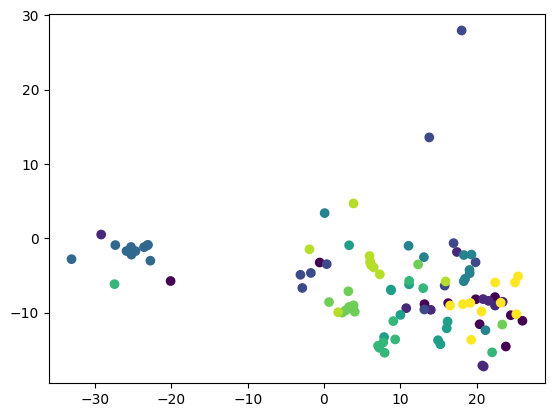

In [ ]:
cluster_model = sklearn.manifold.TSNE(2)
# device="cuda"
batch = val_loader.__iter__().__next__()
cutted = cluster_model.fit_transform(model(batch[0].to(device)).cpu().detach())
plt.scatter(cutted[0:100,0], cutted[0:100,1], c=batch[1][0:100])

In [ ]:
def __accuracy(data, target, net):
  embeddings = net(data)
  data_new = []
  dd = []
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  distances_slice = []
  answers = []
  except_list = []
  for i in num_list:
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    positive_final = random.choice(positive)
    negative_final = random.choice(negative)
    distances_slice.append(dist[i][positive_final].item())
    distances_slice.append(dist[i][negative_final].item())
    answers.append(1)
    answers.append(0)
    data_new.append([data[i], data[positive_final]])
    data_new.append([data[i], data[negative_final]])
    dd.append([i, positive_final])
    dd.append([i, negative_final])
  return distances_slice, answers,data_new,dd

100%|██████████| 27/27 [00:42<00:00,  1.58s/it]


(400,)


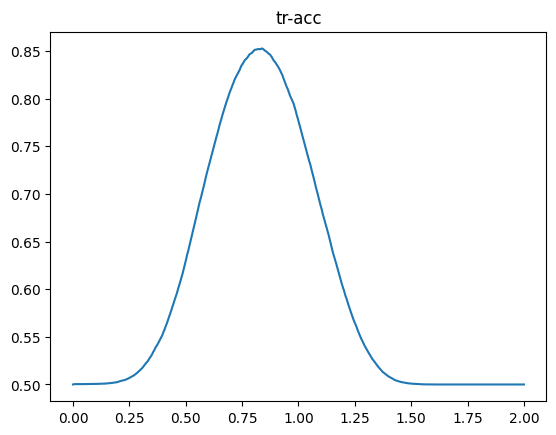

In [ ]:
dist = []
answer = []
data_new = []
dd = []
model.eval()
for batch, target in tqdm.tqdm(val_loader):
      batch = batch.to(device)
      target = target.to(device)
      dist_, answer_, data_new_, dd_ = __accuracy(batch, target, model)
      dd.extend(dd_)
      dist.extend(dist_)
      answer.extend(answer_)
      data_new.extend(data_new_)
      acc_list = []
      ta_list = []
      fa_list = []
      dansity = 400
for threshold in np.linspace(0,2,dansity):
      correct = 0
      ta = 0
      fa = 0
      for i in range(len(answer)):
        if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
          correct += 1
        if dist[i] < threshold and answer[i] == 1:
          ta += 1
        if dist[i] < threshold and answer[i] == 0:
          fa += 1
      acc_list.append(correct/len(answer))
      ta_list.append(ta/len(answer)*2)
      fa_list.append(fa/len(answer)*2)
if True:
  print(np.array(acc_list).shape)
  plt.plot(np.linspace(0,2,dansity), np.array(acc_list))
  plt.title("tr-acc")
  plt.show()
max_thr = np.linspace(0,2,dansity)[np.array(acc_list).argmax()]
max_arg = np.array(acc_list).argmax()

In [ ]:
np.array(acc_list).max()

np.float64(0.8527099463966646)

In [ ]:
len(data_new)

33580

In [ ]:
len(answer)

33580

In [ ]:
len(dist), len(dd)

(33580, 33580)

In [ ]:
n = 17

In [ ]:
dist[n], answer[n]

(0.6868906021118164, 0)

In [ ]:
max_thr

np.float64(0.8571428571428571)

(np.float64(-0.5), np.float64(111.5), np.float64(111.5), np.float64(-0.5))

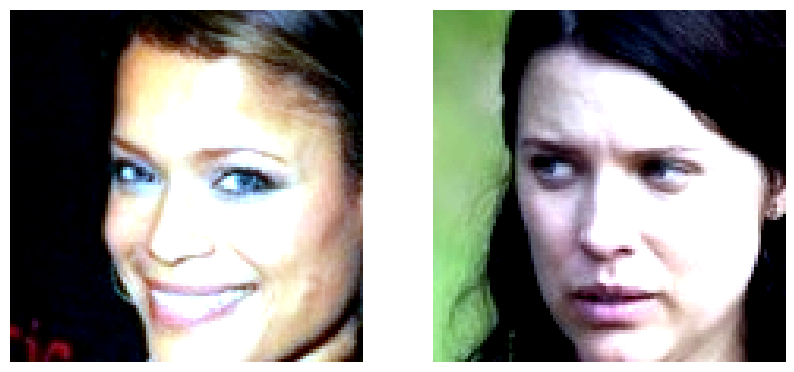

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,6))
axes[0].imshow(data_new[n][0].cpu().permute(1,2,0)*0.5+0.5)
axes[1].imshow(data_new[n][1].cpu().permute(1,2,0)*0.5+0.5)
axes[1].axis('off')
axes[0].axis('off')